In [1]:
from stock_frontend.faststock import Stock
from stock_frontend.safeacc import SafeAccountController as Account
from stock_frontend.strats import SimpleStrat

from tqdm import tqdm
from statistics import mean
from time import sleep

import matplotlib.pyplot as plt
import random

# Stock simulation
Please, make sure that `solana-test-validator` and `solana logs` are running and `sender` program is deployed.<br>
After a simulation we can see prices plot, `stock.log` file has a history of transactions in model, solana logs show logs from Solana's localnet blockchain

  0%|          | 0/5 [00:00<?, ?it/s]

Creating accounts...


 10%|█         | 1/10 [00:29<04:25, 29.51s/it]

Simulation...


100%|██████████| 10/10 [06:40<00:00, 40.06s/it]


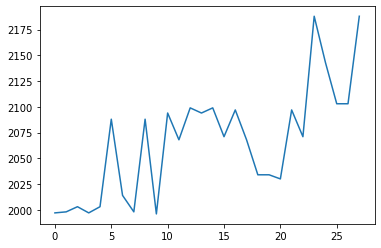

In [2]:
random.seed()
s = Stock('cfg.yml', 'stock.log')
accs_amount = 5

print("Creating accounts...")
accounts = [Account(s) for _ in tqdm(range(accs_amount))]
bots = [SimpleStrat(acc, 2000 + random.randint(-5, 5)) for acc in accounts]
iters = 10
noise_freq = 2

ths = []

print("Simulation...")
for i in tqdm(range(iters)):
    
    av_th = mean([bot.threshold for bot in bots])
    ths.append(av_th)
    
    for bot in bots:
        if i != 0 and i % noise_freq == 0:
             bot.set_threshold(max(2, bot.threshold + random.randint(-100, 105)))

        bot.make_decision()
        bot.acc.check_balance()

    s.dump_accounts_table()
    s.dump_order_book()
    random.shuffle(bots)

prices = s.history
plt.plot(prices)
plt.show()

In [5]:
s.dump_solana_balances()
s.dump_accounts_table()
s.__del__()
print("Watch stock.log to see balances from sim and blockchain match")

0it [00:00, ?it/s]

Waiting...
Watch stock.log to see balances from sim and blockchain match


# Examples of programs calls

In [6]:
def get_pub(keypair):
    return keypair[32:]

## Send lamports
You can change acc1_lamps, acc2_lamps and send_lamps to watch the difference<br>
**Make sure sender is deployed!**

In [7]:
from stock_frontend.rust_client import SolanaClient, gen_keypair

In [8]:
cli = SolanaClient('cfg.yml')

In [9]:
acc1 = bytes(gen_keypair())
acc2 = bytes(gen_keypair())
acc1_lamps = 153
acc2_lamps = 515
send_lamps = 18

In [10]:
cli.create_account(acc1, acc1_lamps)

True

In [11]:
cli.get_balance(get_pub(acc1))

153

In [12]:
cli.create_account(acc2, acc2_lamps)

True

In [13]:
cli.get_balance(get_pub(acc2))

515

In [14]:
cli.send_lamports(get_pub(acc1), get_pub(acc2), 18)

True

In [15]:
print("Acc1 expected:", acc1_lamps - send_lamps)
print("Acc2 expected:", acc2_lamps + send_lamps)

Acc1 expected: 135
Acc2 expected: 533


In [16]:
print("Acc1:", cli.get_balance(get_pub(acc1)))
print("Acc2:", cli.get_balance(get_pub(acc2)))
print("Watch Solana logs!")

Acc1: 135
Acc2: 533
Watch Solana logs!


## Send message to localnet's logs
**Make sure messenger is deployed**

In [17]:
message = "Hello from on-chain distributed runtime!\nGet ready for something..\n"

In [18]:
cli.send_message_to_logs(message)
print("Watch logs!")

Watch logs!


## Accounts as storage
**Make sure setter is deployed**

In [19]:
acc3 = bytes(gen_keypair())
cli.create_account_with_space(acc3, space=32)

True

In [20]:
data = b"Say hi! Stay high! =)"
cli.set_account_data(acc3, data)

True

In [21]:
acc_data = bytes(cli.get_account_data(get_pub(acc3)))
acc_data.decode("ascii")

'Say hi! Stay high! =)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'

# solanastocksim
## Fun stock simulator integrated with Solana blockchain

### Structure
Whole thing consists from several parts:
 - _faststock.py, strats.py, safeacc.py_ - parts of stock exchange model. They stand for trade simulation
 - _rust_client_ - wrapper of Solana's RPC client & Python interface for stock model to track transactions on Solana's blockchain
 - _client.py_ - Python RPC client wrapper with SolanaPy python package, just a python implementation of rust_client (it was created to study API)
 - _sender, setter, messenger_ - on-chain programs, that are to be deployed on a localnet Solana's blockchain

### Run
Ready-to-use docker image:<br>

First terminal (run localnet Solana blockchain):<br>
`$ cd solanastocksim`<br>
`$ solana-test-validator -r`<br>

Second terminal (listen its logs):<br>
`$ cd solanastocksim`<br>
`$ solana logs`<br>

Third terminal (deploy on-chain programs and run exmaples notebook):<br>
`$ cd solanastocksim/stock_backend`<br>
`$ ./deploy.sh`<br>
`$ source ~/venv/bin/activate`<br>
`$ jupyter-notebook`<br>
Run example.ipynb cell-by-cell<br>
_Be careful! Recommended system requirements for Solana's localnet are 24 logical CPUs and 64GB of memory, on _

### Build
#### Build client:
`$ cd solanastocksim/stock_frontend/rust_client`<br>
`$ cargo +nightly build --target-dir ../build`<br>
#### Build on-chain programs:
`$ cd solanastocksim/stock_backend`<br>
`$ cargo build-bpf --bpf-out-dir build`<br>


Configure paths in `solanastocksim/cfg.yml`

